In [1]:
from rouge_score import rouge_scorer

scorer = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=True)

def evaluate(col, score_df, answer=False):
    if answer:
        res = "answer"
    else:
        res = "result"
    def f1(row):
        scores = scorer.score(row['gold_answer'], row[f'{col}_{res}'])
        return scores['rougeL'].fmeasure
    def rc(row):
        scores = scorer.score(row['gold_answer'], row[f'{col}_{res}'])
        return scores['rougeL'].recall
    def pre(row):
        scores = scorer.score(row['gold_answer'], row[f'{col}_{res}'])
        return scores['rougeL'].precision
    score_df[f'{col}_f1'] = score_df.apply(f1, axis=1)
    score_df[f'{col}_rc'] = score_df.apply(rc, axis=1)
    score_df[f'{col}_pre'] = score_df.apply(pre, axis=1)

Long memory score

In [46]:
import pandas as pd

number = 500
answer_df = pd.read_json("MSC_eval.json", lines=True)
# answer_df = pd.read_json("MSC_score_v1.json", lines=True)
score_df = answer_df[:number]

In [47]:
answer=False
evaluate('long_mem', score_df, answer=answer)
evaluate('long_mem_recall', score_df, answer=answer)
long_mem_means = score_df[['long_mem_f1', 'long_mem_rc', 'long_mem_pre']].mean()
long_mem_recall_means = score_df[['long_mem_recall_f1', 'long_mem_recall_rc', 'long_mem_recall_pre']].mean()
print(long_mem_means)
print(long_mem_recall_means)

long_mem_f1     0.019236
long_mem_rc     0.689946
long_mem_pre    0.009845
dtype: float64
long_mem_recall_f1     0.038488
long_mem_recall_rc     0.704379
long_mem_recall_pre    0.020117
dtype: float64


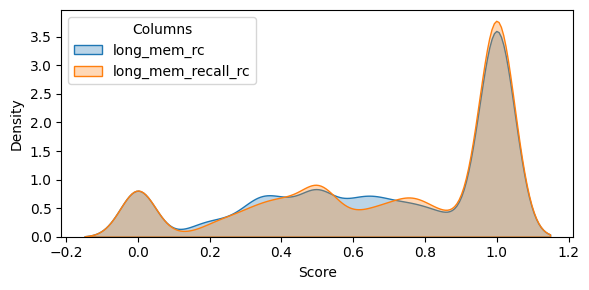

In [48]:
import seaborn as sns
import matplotlib.pyplot as plt

columns = ['long_mem_rc', 'long_mem_recall_rc']

plt.figure(figsize=(6, 3))

for i, column in enumerate(columns):
    data = score_df[column]
    sns.kdeplot(data, label=column, fill=True, alpha=0.3, bw_adjust=0.5)
    
plt.xlabel("Score")
plt.ylabel("Density")
plt.legend(title="Columns")
plt.tight_layout()
plt.show()


In [30]:
score_df[score_df['long_mem_recall_rc']<=0.5].index

Index([11, 12, 13, 15, 17, 18, 19, 20, 23, 27, 28, 31, 33, 37, 38, 39, 41, 46,
       49, 53, 55, 56, 58, 59, 60, 61, 63, 68, 70, 71, 75, 76, 77, 79, 88, 89,
       91, 92, 95, 96],
      dtype='int64')

In [49]:
score_df.to_json("MSC_score_0211.json", orient='records', lines=True)

Short memory score

In [ ]:
import pandas as pd

number = 500
answer_df = pd.read_json("s_MSC_eval.json", lines=True)
# answer_df = pd.read_json("s_MSC_score_v1.json", lines=True)
score_df = answer_df[:number]
evaluate('short_mem', score_df)

In [7]:
short_mem_means = score_df[['short_mem_f1', 'short_mem_rc', 'short_mem_pre']].mean()
print(short_mem_means)

short_mem_f1     0.031469
short_mem_rc     0.826127
short_mem_pre    0.016256
dtype: float64


In [77]:
score_df.to_json("s_MSC_score.json", orient='records', lines=True)

LLM judge

In [50]:
from dotenv import load_dotenv
from openai import OpenAI
import os

load_dotenv()
client = OpenAI(api_key=os.getenv("OPENAI_API_KEY"))

def llm_create(prompt):
        messages = [{"role": "user", "content": prompt}]
        completion = client.chat.completions.create(
            model="gpt-4o-mini",
            messages=messages,
            temperature=0
        )
        return completion.choices[0].message.content

judge_prompt = """Your task is to label an answer to a question as ‘CORRECT’ or ‘WRONG’.

You will be given the following data:

A question (posed by user to assistant).
A ‘gold’ (ground truth) answer.
A retrieve result, which you will score as CORRECT/WRONG.
The point of the question is to ask about something one user should know about the other user based on their prior conversations.

The gold answer will usually be a concise and short answer that includes the referenced topic. For example:
Question: Do you remember what I got the last time I went to Hawaii?
Gold answer: A shell necklace

If the returned document contains content or memory supporting the answer, it should be counted as CORRECT.

Now it’s time for the real question:
Question: {question}
Gold answer: {gold_answer}
Retrieve result: {retrieve_result}

Answer with CORRECT or WRONG only."""

In [51]:
import pandas as pd
number = 500
answer_df = pd.read_json("MSC_score_0211.json", lines=True)
score_df = answer_df[:number]

In [52]:
for i in range(number):
    row = score_df.iloc[i]
    p = judge_prompt.format(question=row['question'], gold_answer=row['gold_answer'], retrieve_result=row['long_mem_result'])
    res = llm_create(p)
    score_df.at[i, 'long_mem_judge'] = res
    p = judge_prompt.format(question=row['question'], gold_answer=row['gold_answer'], retrieve_result=row['long_mem_recall_result'])
    res = llm_create(p)
    score_df.at[i, 'long_mem_recall_judge'] = res

/tmp/ipykernel_312378/791008106.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  score_df.at[i, 'long_mem_judge'] = res
/tmp/ipykernel_312378/791008106.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  score_df.at[i, 'long_mem_recall_judge'] = res


In [53]:
for i in range(number):
    res = score_df.at[i, 'long_mem_judge']
    if 'CORRECT' in res:
        score_df.at[i, 'long_mem_accuracy'] = 1
    elif 'WRONG' in res:
        score_df.at[i, 'long_mem_accuracy'] = 0
    res = score_df.at[i, 'long_mem_recall_judge']
    if 'CORRECT' in res:
        score_df.at[i, 'long_mem_recall_accuracy'] = 1
    elif 'WRONG' in res:
        score_df.at[i, 'long_mem_recall_accuracy'] = 0
print(f"long_mem_accuracy: {score_df['long_mem_accuracy'][:number].sum()/number}")
print(f"long_mem_recall_accuracy: {score_df['long_mem_recall_accuracy'][:number].sum()/number}")

long_mem_accuracy: 0.59
long_mem_recall_accuracy: 0.686


/tmp/ipykernel_312378/2082087171.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  score_df.at[i, 'long_mem_accuracy'] = 1
/tmp/ipykernel_312378/2082087171.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  score_df.at[i, 'long_mem_recall_accuracy'] = 1


In [51]:
score_df.to_json("MSC_score_0212.json", orient='records', lines=True)

### MemGPT score

In [2]:
import pandas as pd

number = 500
answer_df = pd.read_json("memgpt_MSC_eval.json", lines=True)
score_df = answer_df[:number]

In [5]:
answer=False
evaluate('memgpt', score_df, answer=True)
memgpt_means = score_df[['memgpt_f1', 'memgpt_rc', 'memgpt_pre']].mean()
print(memgpt_means)

memgpt_f1     0.140798
memgpt_rc     0.508935
memgpt_pre    0.086431
dtype: float64
